In [1]:
# Installing the required libraries.
!pip install tensorflow 
!pip install opencv-contrib-python moviepy pydot
!pip install twilio
!pip install -q keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached moviepy-1.0.3.tar.gz (388 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

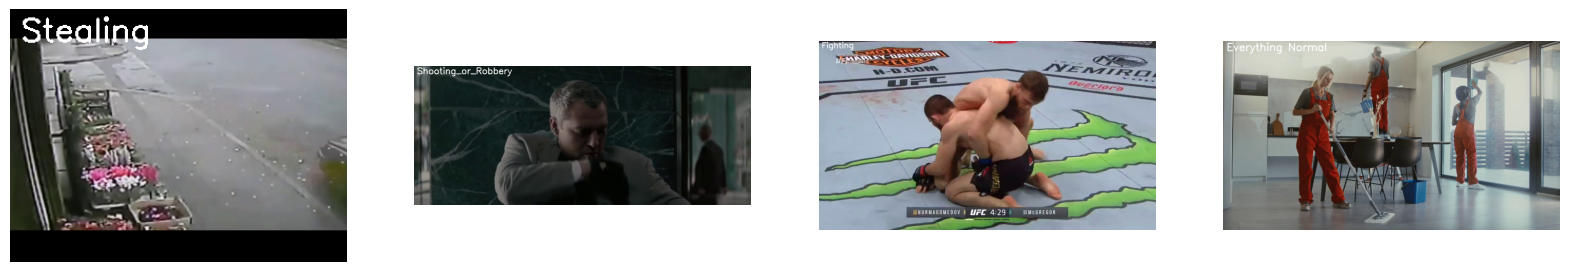

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('DataSets')

random_range = random.sample(range(len(all_classes_names)), 4)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'DataSets/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'DataSets/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [6]:
# Specify the height and width of each video frame.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 40

# Specifying the directory containing dataset.
DATASET_DIR = "DataSets"

# Specifying the list containing the names of the classes used for training.
CLASSES_LIST = ["Everything Normal","Fighting","Shooting_or_Robbery", "Stealing"]

In [7]:
def frames_extraction(video_path):
    
    # Initialize an empty list to store video frames.
    frames_list = []

    # Open the video file for reading.
    video_reader = cv2.VideoCapture(video_path)

    # Retrieve the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Determine the interval at which frames will be sampled for extraction.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the frames of the video.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the position of the video's current frame.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read the current frame from the video.
        success, frame = video_reader.read()

        # Check if the frame was successfully read.
        if not success:
            break

        # Resize the frame to a fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame to ensure pixel values are within the range of 0 to 1.
        normalized_frame = resized_frame / 255

        # Append the normalized frame to the list of frames.
        frames_list.append(normalized_frame)

    # Release the video capture object once done.
    video_reader.release()

    # Return the list of frames extracted from the video.
    return frames_list

In [8]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Everything Normal
Extracting Data of Class: Fighting
Extracting Data of Class: Shooting_or_Robbery
Extracting Data of Class: Stealing


In [10]:
# Using Keras's to_categorical method 
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

### **<font style="color:rgb(134,19,348)"> Plotting Model’s Loss & Accuracy Curves</font>**




In [12]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

### **<font style="color:rgb(134,19,348)"> Construct the Model</font>**



In [13]:
def create_LRCN_model():
    
    # We will use a Sequential model for model construction.
    model = Sequential()

    # Defining the Model Architecture.

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [14]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 40, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 40, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 40, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 40, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 40, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 40, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 40, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 40, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 40, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 40, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 40, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


### **<font style="color:rgb(134,19,348)"> Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [15]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs =40,batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 504ms/step - accuracy: 0.2369 - loss: 1.4114 - val_accuracy: 0.4658 - val_loss: 1.3558
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 421ms/step - accuracy: 0.3203 - loss: 1.3794 - val_accuracy: 0.2466 - val_loss: 1.3502
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 420ms/step - accuracy: 0.3337 - loss: 1.3255 - val_accuracy: 0.4521 - val_loss: 1.1770
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 423ms/step - accuracy: 0.4597 - loss: 1.1027 - val_accuracy: 0.5068 - val_loss: 1.1130
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 424ms/step - accuracy: 0.5267 - loss: 1.0632 - val_accuracy: 0.5342 - val_loss: 1.1218
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 424ms/step - accuracy: 0.5494 - loss: 1.0054 - val_accuracy: 0.5342 - val_loss: 1.0102
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 427ms/step - accuracy: 0.5728 - loss: 0.9441 - val_accuracy: 0.5616 - val_loss: 0.9455
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 31s 425ms/step - accuracy: 0.6308 - loss: 0.8883 - val_accu

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

In [16]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6366 - loss: 0.9168


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses.

In [17]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
date_time_format = '%Y_%m_%d__%H_%M_%S'
# Get the current Date and Time in a DateTime Object.
current_date_time_dt = dt.datetime.now()
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Plotting Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


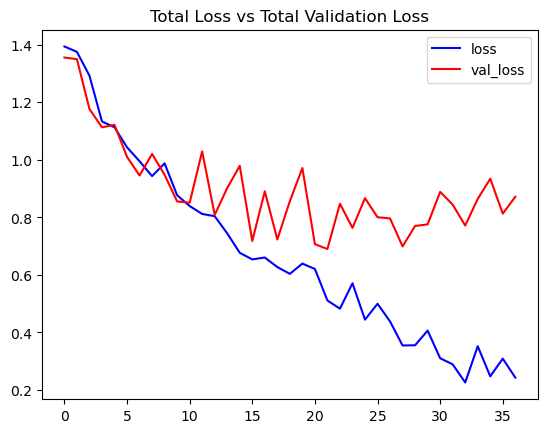

In [18]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

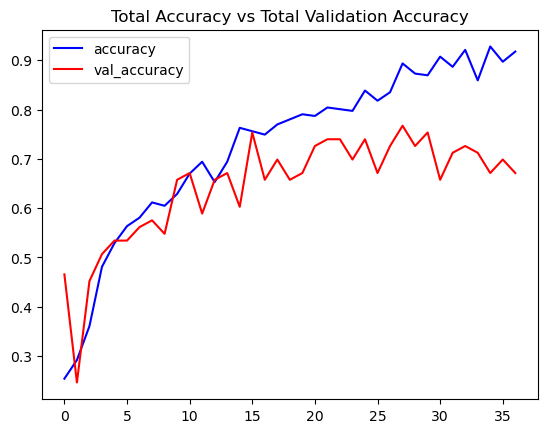

In [19]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the `LRCN` model to test on real time videos.

### **<font style="color:rgb(134,19,348)">Creating a Function To Perform Real Time Action Recognition on Videos and Sending Alert to the Registered user via sms using twilio API</font>**


In [31]:
######################################################
#Alert: To stop the live anomaly detection firtly pause the kernel then run the next code 
#######################################################
import cv2
import numpy as np
from twilio.rest import Client
import time

# Twilio credentials
account_sid = 'AC6a853d9302438ef8b3f8902cd53a866f'
auth_token = '4c8ef33f8112d0dab7f6a9304ccf005a'
from_phone = '+15037665007'
to_phone = '+916206938533'

# Initialize Twilio Client
client = Client(account_sid, auth_token)

# Define the preprocess_frame function
def preprocess_frame(frame):
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    frame = frame / 255.0
    return frame

# Send SMS function
def send_sms(message):
    try:
        message = client.messages.create(
            body=message,
            from_=from_phone,
            to=to_phone
        )
        print(f"SMS sent successfully. SID: {message.sid}")
    except Exception as e:
        print(f"Error sending SMS: {e}")

def predict_realtime_action():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    frames_sequence = []
    start_time = None
    action_count = 0

    cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Error: Could not read frame from webcam.")
            break

        preprocessed_frame = preprocess_frame(frame)
        frames_sequence.append(preprocessed_frame)

        if len(frames_sequence) == SEQUENCE_LENGTH:
            frames_array = np.array(frames_sequence).astype(np.float32)
            frames_array = np.expand_dims(frames_array, axis=0)

            predicted_probabilities = LRCN_model.predict(frames_array)[0]
            predicted_label = np.argmax(predicted_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Webcam Feed', frame)

            if predicted_class_name == 'Everything Normal':
                if start_time is None:
                    start_time = time.time()
                else:
                    if time.time() - start_time >= 30 and action_count == 0:
                        send_sms("Alert: Anomaly Detected. Anomaly has persisted for 30 seconds.")
                        action_count = 1
            else:
                start_time = None
                action_count = 0

            frames_sequence = []

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

predict_realtime_action()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

In [32]:
#To close the camera run this cell after pausing the kernel
cv2.destroyAllWindows()

### **<font style="color:rgb(134,19,348)">Creating a Function to Retrieve videos from local storage:</font>**
This below code can be used if you want to predict action on the videos stored within the local file of your pc where code is stored.
You have to just pass the path to the fetch_video() method.


In [20]:
import shutil

In [21]:
####################################
def fetch_videos(source_path, destination_directory):
    """Copy video file from source to destination."""
    video_title = os.path.basename(source_path)
    destination_path = os.path.join(destination_directory, video_title)

    # Copy the video file from source to destination
    shutil.copy(source_path, destination_path)

    return video_title

In [22]:
import cv2
import numpy as np

def predict_single_action(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video_writer = cv2.VideoWriter(output_file_path, fourcc, video_reader.get(cv2.CAP_PROP_FPS),
                                   (original_video_width, original_video_height))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Convert frames list to numpy array and reshape for model input
    frames_array = np.array(frames_list)
    frames_array = frames_array.reshape((1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Assuming 3 channels (RGB)

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(frames_array)[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
    #########printing all probabbilities
    print(CLASSES_LIST)
    print(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Write predicted class name on top of the frame.
    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Write the frame to the video file
    video_writer.write(frame * 255)  # Convert back to 0-255 range

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')


In [ ]:
# Retrieve video from file.
video_title = fetch_videos('Shoo2.mp4', test_videos_directory)

# Construct tihe input youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}'

# Construct the output video path.
output_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'


# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path,output_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path,output_file_path, audio=False, target_resolution=(300,None)).ipython_display()#
#VideoFileClip(output_file_path).ipython_display(width = 700)